# EJ sweep Floquet analysis

Following up the previous transmon demo, we examine the possible experimental situation where the cavity frequency to use is fixed and we instead have the freedom to sweep a transmon parameter. Here specifically we fix the transmon EC and sweep EJ.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

In [6]:
filepath = ft.generate_file_path("h5py", "transmon_EJ_sweep_floquet", "out")

num_states = 20
qubit_params = {"EJ": 20.0, "EC": 0.2, "ng": 0.25, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]

# fix the drive frequency ("cavity" frequency) to a single value
omega_d_values = 2.0 * np.pi * np.array([8.0])
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.1, 59)


def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


# we define this function which takes EJ as input so that we can parallelize calls
def sweep_tmon_EJ(EJ: float) -> tuple[np.ndarray, np.ndarray]:
    _qubit_params = {"EJ": EJ, "EC": 0.2, "ng": 0.25, "ncut": 41}
    _tmon = scq.Transmon(**_qubit_params, truncated_dim=num_states)
    _H0, _H1 = get_H0_H1(_tmon)
    _chi_to_amp = ft.ChiacToAmp(_H0, _H1, state_indices, omega_d_values)
    _drive_amplitudes = _chi_to_amp.amplitudes_for_omega_d(chi_ac_values)
    _model = ft.Model(
        _H0, _H1, omega_d_values=omega_d_values, drive_amplitudes=_drive_amplitudes
    )
    _floquet_analysis = ft.FloquetAnalysis(_model, state_indices=state_indices)
    _data_vals = _floquet_analysis.run(filepath=None)
    return _data_vals["displaced_state_overlaps"], _data_vals["avg_excitation"]

In [ ]:
# parallelize the calls to sweep_tmon_EJ
EJ_values = np.linspace(15.0, 25.0, 120)
result = list(ft.parallel_map(6, sweep_tmon_EJ, EJ_values))
displaced_state_overlaps, avg_excitation = list(zip(*result, strict=True))

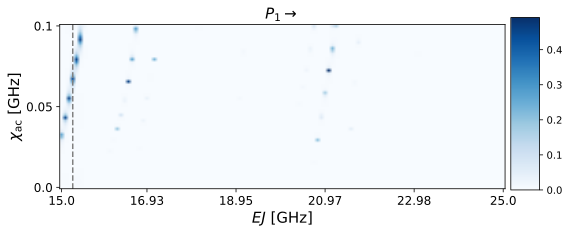

In [7]:
tmon_idx = 1
EJ_idx = 3

# indices are EJ, omega_d, amp, tmon state
plot_data = np.clip(
    1 - np.array(displaced_state_overlaps)[:, 0, :, tmon_idx].T ** 2, 0.0, 0.5
)
fig, ax = plt.subplots(figsize=(8, 8))
xticks = EJ_values
yticks = chi_ac_values / (2.0 * np.pi)
num_x_pts = len(xticks)
num_y_pts = len(yticks)
im = plt.imshow(
    plot_data, origin="lower", cmap="Blues", aspect=0.75, interpolation="none"
)
plt.axvline(EJ_idx, color="grey", ls="--")
ax.set_title(f"$P_{tmon_idx}$" + r"$\rightarrow$", fontsize=15)
xticklabel_locations = np.linspace(0, num_x_pts - 1, 6, dtype=int)
ax.set_xticks(xticklabel_locations)
ax.set_xticklabels(
    np.array(np.around(xticks[xticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
yticklabel_locations = np.linspace(0, num_y_pts - 1, 3, dtype=int)
ax.set_yticks(yticklabel_locations)
ax.set_yticklabels(
    np.array(np.around(yticks[yticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
ax.set_ylabel(r"$\chi_{\rm ac}$ [GHz]", fontsize=15)
ax.set_xlabel(r"$EJ$ [GHz]", fontsize=15)
cax = plt.axes([0.91, 0.35, 0.05, 0.3])
cbar = plt.colorbar(im, cax=cax)
plt.show()

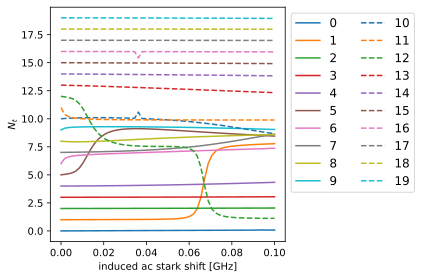

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(range(num_states), color_ls_alpha_cycler, strict=False):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        np.array(avg_excitation)[EJ_idx, 0, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel(r"$N_{t}$")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()